In [1]:
import json
import random
from pathlib import Path

import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader


In [2]:
class PairedAudioDataset(Dataset):
    def __init__(self, json_path, wav8k_dir="wav8k", wav16k_dir="wav16k", audio_duration=1.0, sample_rate=16000):
        self.audio_duration = audio_duration
        self.sample_rate = sample_rate
        self.num_samples = int(audio_duration * sample_rate)

        self.wav8k_dir = Path(wav8k_dir)
        self.wav16k_dir = Path(wav16k_dir)

        with open(json_path) as f:
            self.filenames = json.load(f)

    def __len__(self):
        return len(self.filenames)

    def _load_and_crop(self, wav_name):
        path_8k = self.wav8k_dir / wav_name
        path_16k = self.wav16k_dir / wav_name

        waveform8k, sr = torchaudio.load(path_8k)
        waveform16k, sr = torchaudio.load(path_16k)

        if waveform8k.shape[1] > self.num_samples:
            # crop if longer
            max_offset = waveform8k.shape[1] - self.num_samples
            offset = random.randint(0, max_offset)
            waveform8k = waveform8k[:, offset:offset + self.num_samples]
            waveform16k = waveform16k[:, offset:offset + self.num_samples]
        else:
            # pad if shorter
            waveform8k = torch.nn.functional.pad(waveform8k, (0, self.num_samples - waveform8k.shape[1]))
            waveform16k = torch.nn.functional.pad(waveform16k, (0, self.num_samples - waveform16k.shape[1]))
        return waveform8k, waveform16k

    def __getitem__(self, idx):
        wav_name = self.filenames[idx]
        x8k, x16k = self._load_and_crop(wav_name)
        return x8k, x16k


In [3]:
dataset = PairedAudioDataset("filelist.json")

In [4]:
for x8, x16 in dataset:
    break

In [7]:
x8.shape, x16.shape

(torch.Size([1, 16000]), torch.Size([1, 16000]))

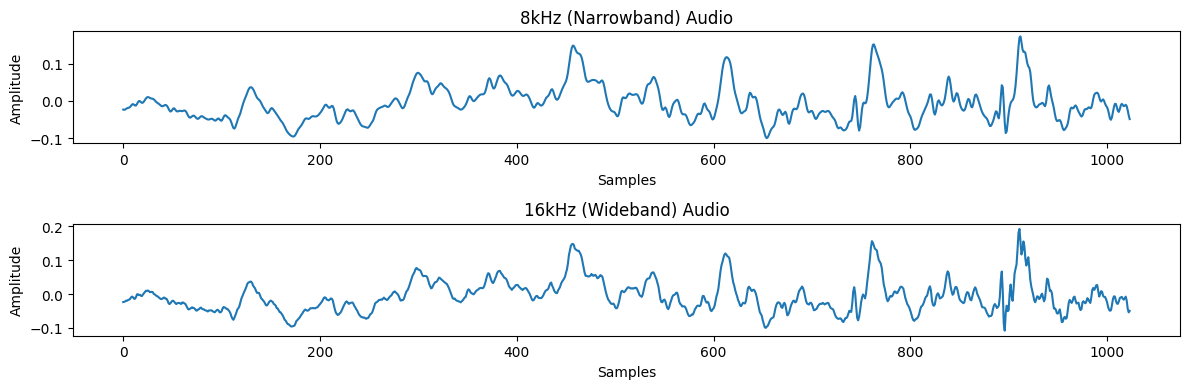

In [10]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 4))

# Plot low-bandwidth audio (8k)
plt.subplot(2, 1, 1)
plt.plot(x8[0, :1024])
plt.title("8kHz (Narrowband) Audio")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

# Plot full-bandwidth audio (16k)
plt.subplot(2, 1, 2)
plt.plot(x16[0, :1024])
plt.title("16kHz (Wideband) Audio")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()